In [41]:
import numpy as np
import pandas as pd
from keras.models import load_model
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score
import efficientnet.keras
import keras
import itertools

In [2]:
baseline=load_model("C:/Users/pr503/Projects/skinn/Skin_Cancer_Seq_32.h5")
DenseNet=load_model("C:/Users/pr503/Projects/skinn/Skin_Cancer_DenseNet201.h5")
VGG16=load_model("C:/Users/pr503/Projects/skinn/Skin_Cancer_VGG16.h5")
ResNet=load_model("C:/Users/pr503/Projects/skinn/Skin_Cancer_ResNet.h5")

In [3]:
base_models=[baseline,DenseNet,VGG16,ResNet]

In [4]:
data_dir = 'C:/Users/pr503/Projects/skinn/hmnist_32_32_RGB.csv'
data = pd.read_csv(data_dir)
data.head()

,pixel0000,pixel0001,pixel0002,pixel0003,pixel0004,pixel0005,pixel0006,pixel0007,pixel0008,pixel0009,...,pixel3063,pixel3064,pixel3065,pixel3066,pixel3067,pixel3068,pixel3069,pixel3070,pixel3071,label
0,191,151,192,194,154,193,196,152,184,199,...,176,130,144,184,150,170,184,153,176,2
1,23,13,27,55,38,63,107,80,113,142,...,42,25,43,25,14,27,25,14,27,2
2,190,135,150,199,146,162,199,140,159,205,...,165,129,144,155,121,139,133,101,113,2
3,33,16,26,82,51,63,128,87,102,161,...,33,17,26,25,12,16,25,12,15,2
4,154,110,134,188,140,168,210,157,184,220,...,200,158,175,160,124,137,101,70,85,2


In [5]:
Label = data["label"]
Data = data.drop(columns=["label"])

In [6]:
from imblearn.over_sampling import RandomOverSampler 

oversample = RandomOverSampler()
Data, Label  = oversample.fit_resample(Data, Label)
Data = np.array(Data).reshape(-1, 32, 32, 3)
print('Shape of Data :', Data.shape)

Shape of Data : (46935, 32, 32, 3)


In [7]:
Label = np.array(Label)
Label

array([2, 2, 2, ..., 6, 6, 6], dtype=int64)

In [8]:
classes = {4: ('nv', ' melanocytic nevi'),
           6: ('mel', 'melanoma'),
           2 :('bkl', 'benign keratosis-like lesions'), 
           1:('bcc' , ' basal cell carcinoma'),
           0: ('akiec', 'Actinic keratoses and intraepithelial carcinomae'),
           5: ('vasc', ' pyogenic granulomas and hemorrhage'),
           3: ('df', 'dermatofibroma')}

In [9]:
from sklearn.model_selection import train_test_split

X_train , X_test , y_train , y_test = train_test_split(Data , Label , test_size = 0.25 , random_state = 49)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(35201, 32, 32, 3)
(35201,)
(11734, 32, 32, 3)
(11734,)


In [10]:
from keras.utils import to_categorical

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [11]:
from keras.preprocessing.image import ImageDataGenerator

In [12]:
datagen = ImageDataGenerator(rescale=(1./255)
                             ,rotation_range=10
                             ,zoom_range = 0.1
                             ,width_shift_range=0.1
                             ,height_shift_range=0.1)

testgen = ImageDataGenerator(rescale=(1./255))

In [13]:
from keras import Model, Input , layers
from tensorflow.keras.layers import Average

In [14]:
baseline_input = Input(shape=(32,32,3),name='baseline_input')
DenseNet_input = Input(shape=(32,32,3),name='DenseNet_input')
VGG16_input = Input(shape=(32,32,3),name='VGG16_input')
ResNet_input = Input(shape=(32,32,3),name='ResNet_input')

In [15]:
baseline_output=baseline(baseline_input)
DenseNet_output=DenseNet(DenseNet_input)
VGG16_output=VGG16(VGG16_input)
ResNet_output=VGG16(ResNet_input)

In [16]:
ensemble_output = Average()([baseline_output,DenseNet_output,VGG16_output,ResNet_output])

In [17]:
ensemble_model = keras.Model(inputs=[baseline_input,DenseNet_input,VGG16_input,ResNet_input], outputs=ensemble_output)

In [18]:
ensemble_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [19]:
from keras.callbacks import ReduceLROnPlateau

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy'
                                            , patience = 1
                                            , verbose=1
                                            ,factor=0.5
                                            , min_lr=0.00001)

In [20]:
history=ensemble_model.fit([X_train, X_train, X_train,X_train], y_train,
                           epochs=25,
                           batch_size=128,
                           verbose=2,
                           validation_data=([X_test,X_test,X_test,X_test] , y_test),
                           callbacks=[learning_rate_reduction])

Epoch 1/25
276/276 - 283s - loss: 0.1848 - accuracy: 0.9656 - val_loss: 0.2313 - val_accuracy: 0.9472 - lr: 0.0010 - 283s/epoch - 1s/step
Epoch 2/25
276/276 - 268s - loss: 0.1434 - accuracy: 0.9691 - val_loss: 0.2006 - val_accuracy: 0.9659 - lr: 0.0010 - 268s/epoch - 971ms/step
Epoch 3/25

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
276/276 - 268s - loss: 0.1122 - accuracy: 0.9789 - val_loss: 0.2295 - val_accuracy: 0.9622 - lr: 0.0010 - 268s/epoch - 973ms/step
Epoch 4/25
276/276 - 269s - loss: 0.0667 - accuracy: 0.9898 - val_loss: 0.1013 - val_accuracy: 0.9769 - lr: 5.0000e-04 - 269s/epoch - 975ms/step
Epoch 5/25
276/276 - 268s - loss: 0.0465 - accuracy: 0.9943 - val_loss: 0.0936 - val_accuracy: 0.9804 - lr: 5.0000e-04 - 268s/epoch - 971ms/step
Epoch 6/25

Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
276/276 - 268s - loss: 0.0391 - accuracy: 0.9958 - val_loss: 0.0889 - val_accuracy: 0.9781 - lr: 5.0000e-04 - 268s/epoch - 97

In [21]:
def plot_training(hist):
    tr_acc = hist.history['accuracy']
    tr_loss = hist.history['loss']
    val_acc = hist.history['val_accuracy']
    val_loss = hist.history['val_loss']
    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]
    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]

    plt.figure(figsize= (20, 8))
    plt.style.use('fivethirtyeight')
    Epochs = [i+1 for i in range(len(tr_acc))]
    loss_label = f'best epoch= {str(index_loss + 1)}'
    acc_label = f'best epoch= {str(index_acc + 1)}'
    
    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
    plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout
    plt.show()

In [23]:
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt

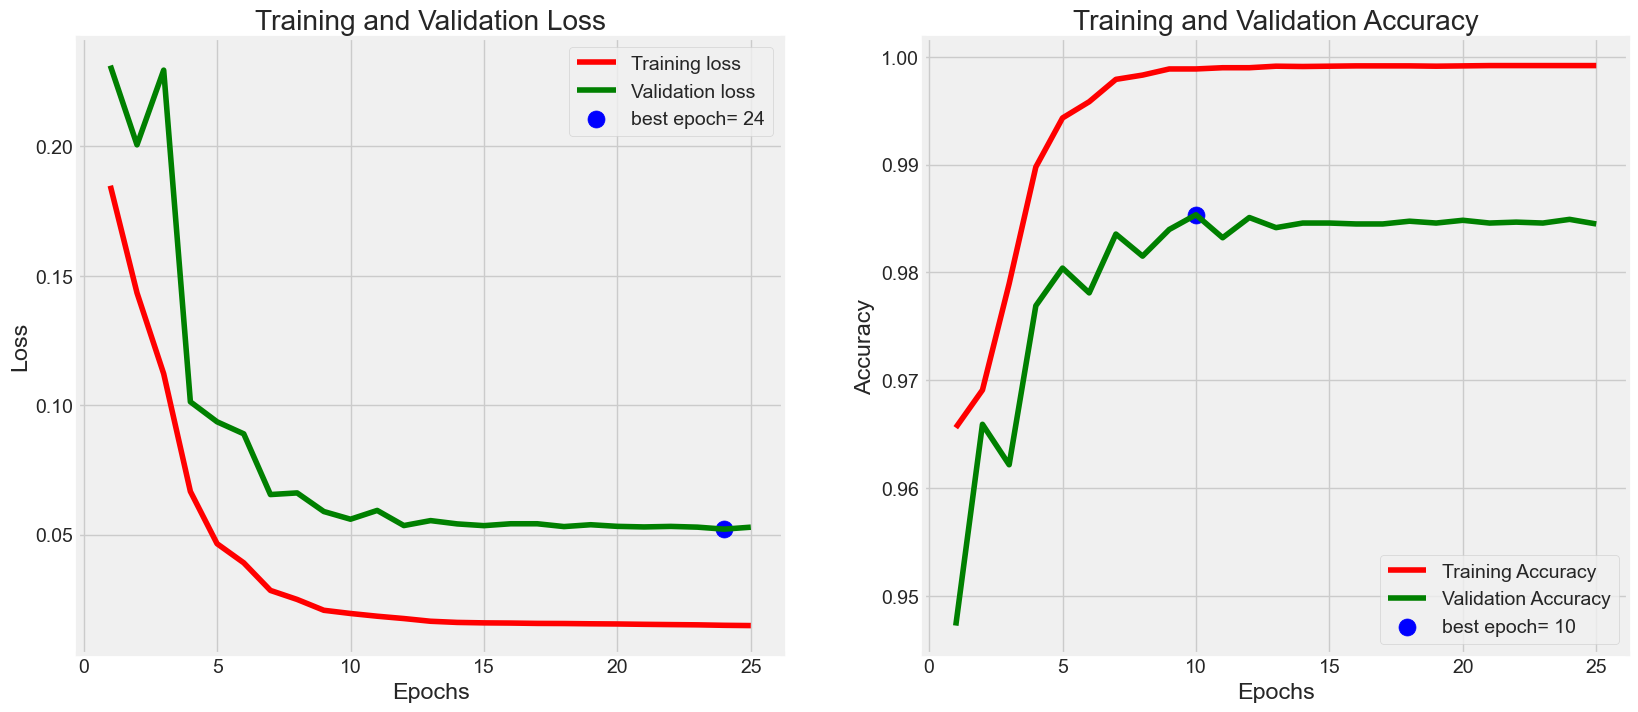

In [24]:
plot_training(history)

In [28]:
train_score = ensemble_model.evaluate([X_train,X_train,X_train,X_train], y_train, verbose= 1)
test_score = ensemble_model.evaluate([X_test,X_test,X_test,X_test], y_test, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

367/367 [==============================] - 60s 163ms/step - loss: 0.0529 - accuracy: 0.9845
Train Loss:  0.014492924325168133
Train Accuracy:  0.9991761445999146
--------------------
Test Loss:  0.05285463482141495
Test Accuracy:  0.9844895005226135


In [37]:
y_true = np.array(y_test)
y_pred = ensemble_model.predict([X_test,X_test,X_test,X_test])

y_pred = np.argmax(y_pred , axis=1)
y_true = np.argmax(y_true , axis=1)

367/367 [==============================] - 64s 169ms/step


In [38]:
classes_labels = []
for key in classes.keys():
    classes_labels.append(key)

print(classes_labels)

[4, 6, 2, 1, 0, 5, 3]


In [39]:
from sklearn.metrics import confusion_matrix, classification_report

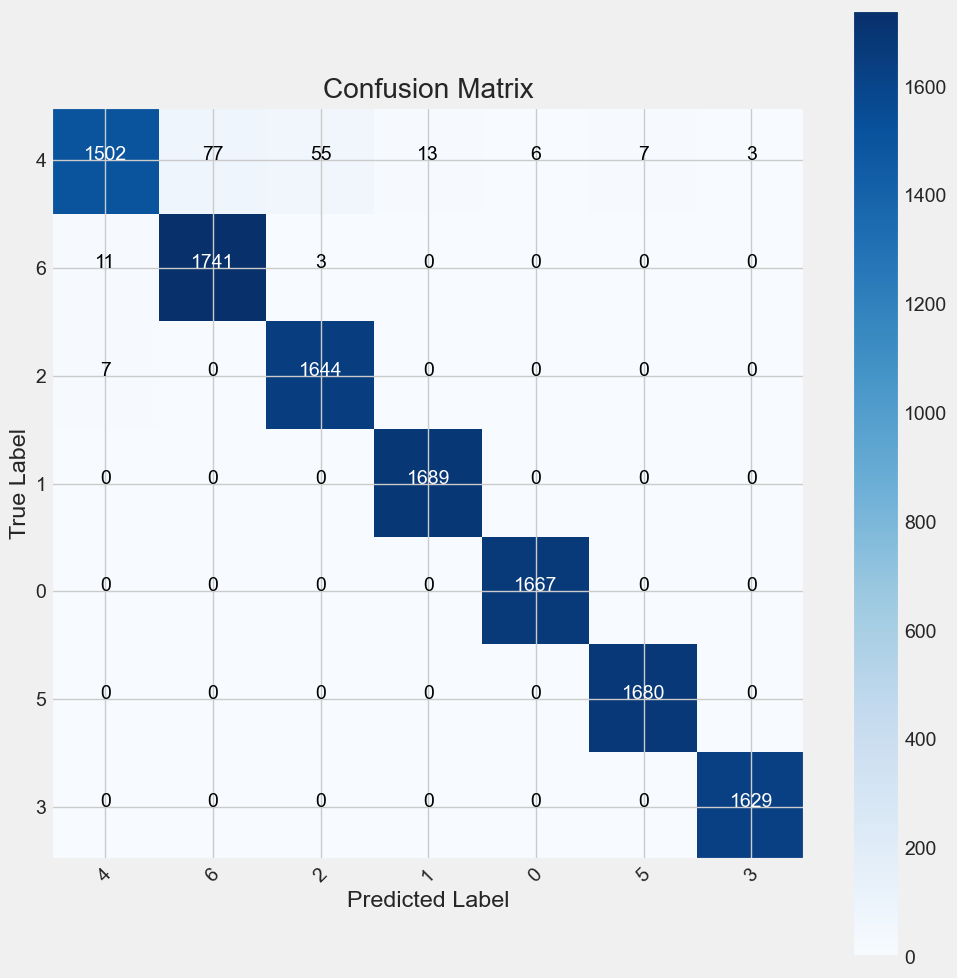

In [42]:
cm = cm = confusion_matrix(y_true, y_pred, labels=classes_labels)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [43]:
keras.backend.clear_session()

In [48]:
ensemble_model.save_weights('test.h5')

In [50]:
!pip install --upgrade h5py

In [51]:
ensemble_model.save('Skin_Cancer_Ensemble.h5')

ValueError: Unable to create dataset (name already exists)